### Evaluating how quickly a back becomes unbalanced
This code simulates a battery pack having cell-to-cell variations. The purpose is to see how quickly we might expect the pack become out of balance after discharging (according to a profile of demanded power versus time) and then charging for multiple cycles. 

Note that the code is doing a lot of computations so executes quite slowly. Progress is reported as the simulation executes so that you can know the present simulation status.

The next Jupyter notebook cell contains the function you learned about in this and the prior lesson for simulating a "random" pack.

In [1]:
% --------------------------------------------------------------------
% simRandPack: Simulate battery pack having Ns cells in series for Nc
% discharge/charge cycles, where all cells in pack can have random
% parameter values (e.g., capacity, resistance, etc.) 
%
% Assumes no hysteresis in the cell model (this could be changed
% fairly easily; hysteresis makes results more difficult to interpret,
% so this assumption is okay for a first analysis, at least).
% --------------------------------------------------------------------
function packData = simRandPack(Ns,Nc,cycleFile,model,randOptions)

  tOpt = randOptions(1); qOpt = randOptions(2); rOpt = randOptions(3);
  sdOpt = randOptions(4); cOpt = randOptions(5); lOpt = randOptions(6);
  profile = load(sprintf('./readonly/%s',cycleFile)); % e.g., 'uddsPower.txt'
  
  % ------------------------------------------------------------------
  % Create storage for all cell states after completion of each cycle
  % ------------------------------------------------------------------
  % maxtime = 26000; % Simulation run time in simulated seconds
  packData.storez = zeros([Ns Nc]);  % create storage for final SOC 
  packData.storeirc = zeros([Ns Nc]);

  % ------------------------------------------------------------------
  % Initialize default states for ESC cell model
  % ------------------------------------------------------------------
  maxSOC = 0.75; % cell SOC when pack is "fully charged" (narrow limits for faster sim)
  minSOC = 0.25; % cell SOC when pack is "fully discharged"
  z  = maxSOC*ones(Ns,1); % start fully charged
  irc = zeros(Ns,1);      % at rest
  ik   = zeros([Ns 1]); % current experienced by each cell

  % Set cell temperatures based on tOpt
  if tOpt, % set to "if 1," to execute, or "if 0," to skip this code
    T = 22.5 + 5*rand([Ns 1]);
  else
    T = 25*ones([Ns 1]);
  end
  % Set self-discharge "cell temperature"
  Tsd  = T - 5 + 10*rand([Ns 1]);
  
  % Set cell module leakage current based on lOpt
  if lOpt,
    leak = 0.01 + 0.002*rand([Ns 1]);
  else
    leak = 0.01*ones([Ns 1]);
  end

  % ------------------------------------------------------------------
  % Default initialization for cells within the pack
  % Note that since T has Ns elements, there is one parameter value
  % per cell (even if all turn out to be identical)
  % ------------------------------------------------------------------
  q   = getParamESC('QParam',T,model);
  rc  = exp(-1./abs(getParamESC('RCParam',T,model)));
  r   = (getParamESC('RParam',T,model)).*(1-rc);
  r0  = getParamESC('R0Param',T,model); 
  rt  = 2*0.000125; % 125 microOhm resistance for each tab
  maxVlim = OCVfromSOCtemp(maxSOC,T,model);
  minVlim = OCVfromSOCtemp(minSOC,T,model);
  eta = ones([Ns 1]);

  % ------------------------------------------------------------------
  % Modified initialization for cell variability
  % ------------------------------------------------------------------
  % Set individual random cell-capacity values
  if qOpt, % set to "if 1," to execute, or "if 0," to skip this code
    q=q-0.25+0.5*rand([Ns 1]);      % random capacity for ea. cell
  end

  % Set individual random cell-resistance values
  if rOpt, % set to "if 1," to execute, or "if 0," to skip this code
    r0 = r0-0.0005+0.0015*rand(Ns,1);
  end
  r0 = r0 + rt; % add tab resistance to cell resistance
  R = sum(r0,1);

  % Set individual random cell-coulombic-efficiency values
  if cOpt, % set to "if 1," to execute, or "if 0," to skip this code
    eta = eta - 0.001 - 0.002*rand([Ns 1]);
  end

  % ------------------------------------------------------------------
  % Now, simulate pack performance using ESC cell model.
  % ------------------------------------------------------------------
  theCycle = 1;
  theState = 'discharge';
  disCnt = 0; % start at beginning of profile
  fprintf('  Starting cycle = 1\n    discharging... \n');
  while theCycle <= Nc,
    v  = OCVfromSOCtemp(z,T,model); % get OCV for each cell
    v  = v - r.*irc;       % add in capacitor voltages
    V  = sum(v);           % Total voltage excluding I*R
    vt = v-ik.*r0;         % Cell terminal voltages

    switch( theState )
      case 'discharge';
        % Get instantaneous demanded pack power, repeating profile
        P = profile(rem(disCnt,length(profile))+1);
        % Compute demanded pack current based on unloaded voltage
        I = V/(2*R) - sqrt(V^2/R^2 - 4*P/R)/2; 
        % Default cell current = pack current
        ik = I*ones(Ns,1);
        if I < 0, % If we happen to be charging this momement
          ik = ik.*eta;
        end
        if min(z) <= minSOC || min(vt) < minVlim,   % stop discharging
          theState = 'charge';
          chargeFactor = 1;
          ik = 0*ik;
          fprintf('    charging... \n');
        end
        disCnt = disCnt + 1;

      case 'charge';                    
        % start charging @ 6.6kW, then taper
        P = -6600/chargeFactor; 
        I = V/(2*R) - sqrt(V^2/R^2 - 4*P/R)/2; 
        I = max(-min(q),I); % limit to 1C charge rate max
        ik = I*eta;                    % Charge coulombic eff.
        if max(vt)>=maxVlim,
          if chargeFactor > 32, % bail after 6.6kW/32 charge
            packData.storez(:,theCycle) = z;
            packData.storeirc(:,theCycle) = irc;
            theState = 'discharge';
            disCnt = 0;
            ik = 0*ik;
            theCycle = theCycle + 1;
            if theCycle <= Nc,
              fprintf('  Starting cycle = %d\n    discharging... \n',theCycle);
            end
          end
          chargeFactor = chargeFactor*2;
        end
      otherwise
        error('charge/discharge state has been corrupted')
    end

    % Simulate self discharge
    if sdOpt == 1,
      rsd = ((-20+0.4*Tsd).*z + (35-0.5*Tsd))*1e3;
      ik  = ik + vt./rsd;
    end
    
    % Simulate leakage current
    ik = ik + leak;
    
    z = z - (1/3600)*ik./q;              % Update each cell SOC
    irc = rc.*irc + (1-rc).*ik;          % Update resistor currents
  end % end while
  fprintf('\n');
  packData.q = q;
  packData.rc = rc;
  packData.r = r;
  packData.r0 = r0;
  packData.eta = eta;
  packData.T = T;
  packData.Tsd = Tsd;
  packData.leak = leak;
end

The next notebook cell contains code to execute the simRandPack function with default parameter values.

In [2]:
% Run the "simRandPack" function
addpath ./readonly       % make sure that the helper functions are in the path
load ./readonly/E2model; % load the ESC cell model to be used
rand('state',1);         % set the random-number state for repeatable simulations

numPacks = 5;            % the number of randomly generated packs to simulate
numCycles = 15;          % the number of discharge/charge cycles to simulate
numCells = 25;           % the number of cells in each pack
simStruct = [];          % a data structure for storing results

% In the simulation, below, all the "random options" are turned on.
% You might be interested in running the code for different configurations 
% to explore sensitivity to each option.
for thePack = 1:numPacks
  fprintf('Running pack %d\n',thePack);
  packData=simRandPack(numCells,numCycles,'uddsPower.txt',model,[1 1 1 1 1 1]);
  simStruct{thePack} = packData;
end

Running pack 1
  Starting cycle = 1
    discharging... 
    charging... 
  Starting cycle = 2
    discharging... 
    charging... 
  Starting cycle = 3
    discharging... 
    charging... 
  Starting cycle = 4
    discharging... 
    charging... 
  Starting cycle = 5
    discharging... 
    charging... 
  Starting cycle = 6
    discharging... 
    charging... 
  Starting cycle = 7
    discharging... 
    charging... 
  Starting cycle = 8
    discharging... 
    charging... 
  Starting cycle = 9
    discharging... 
    charging... 
  Starting cycle = 10
    discharging... 
    charging... 
  Starting cycle = 11
    discharging... 
    charging... 
  Starting cycle = 12
    discharging... 
    charging... 
  Starting cycle = 13
    discharging... 
    charging... 
  Starting cycle = 14
    discharging... 
    charging... 
  Starting cycle = 15
    discharging... 
    charging... 

Running pack 2
  Starting cycle = 1
    discharging... 
    charging... 
  Starting cycle = 2
    dischargin

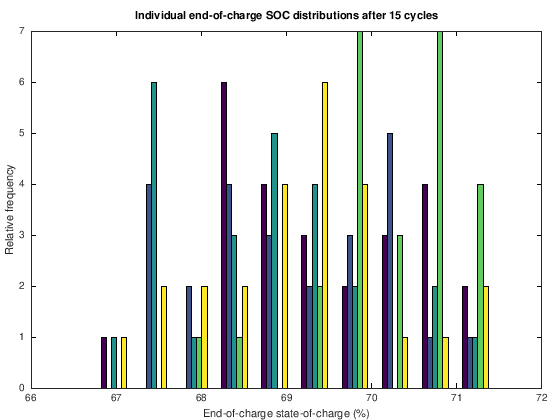

In [3]:
% This code plots a histogram of the relative frequency of end-of-charge SOC after the completion of
% "numCycles" discharge/charge cycles. This helps visualize the spread of SOC values as well as 
% their overall distribution
storez = [];     % initialize a data structure for storing SOC values
cycleNum = 15;   % specify the cycle number for which you desire to see output
for k = 1:length(simStruct),
  packData = simStruct{k};
  storez = [storez packData.storez(:,cycleNum)]; 
end
hist(storez*100)
xlabel('End-of-charge state-of-charge (%)'); ylabel('Relative frequency');
title(sprintf('Individual end-of-charge SOC distributions after %d cycles',cycleNum));

In [4]:
% The difference between minimum SOC and maximum SOC of all cells simulated 
% over a certain number "numCycles" of cycles can also be found
storez = [];     % initialize a data structure for storing SOC values
cycleNum = 15;   % specify the cycle number for which you desire to see output
for k = 1:length(simStruct),
  packData = simStruct{k};
  storez = [storez packData.storez(:,cycleNum)]; 
end
fprintf('The SOC spread, in percent, after %d cycles is %f\n',cycleNum,100*(max(storez(:)) - min(storez(:))))

The SOC spread, in percent, after 15 cycles is 4.715560
